<div align="center">

### Lab 4

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 4: Predicting Stock Price with Deep Learning

</div>

### Introduction

In this lab, we explore the application of time-series datasets using Long Short-Term Memory (LSTM) networks, a type of recurrent neural network, to predict stock prices. Specifically, we will use historical price data from Nvidia to forecast the stock's price for the next day based on the prices of the previous N days. This approach is particularly relevant given the volatile nature of stock markets and the increasing reliance on automated trading systems.

### Objectives

- To understand the fundamentals of LSTM networks and their application in time-series forecasting.
- To develop a predictive model that can accurately forecast Nvidia's stock price for the next day using historical data.

### Dataset

The dataset for this lab is from the "Huge Stock Market Dataset" available on Kaggle. This dataset includes daily prices and volumes for all US stocks and ETFs, with a specific focus on Nvidia (NVDA). The dataset features include:

- **Date**: The recorded data points.
- **Open**: The price at which the stock first traded upon the opening of an exchange on a given trading day.
- **High**: The highest price at which the stock traded during the trading day.
- **Low**: The lowest price at which the stock traded during the trading day.
- **Close**: The price of the stock at closing time.
- **Volume**: The number of shares or contracts traded in a security or an entire market during a given period.
- **OpenInt**: The total number of outstanding derivative contracts, like options or futures. [More details here](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/discussion/121096)

### References

- [Huge Stock Market Dataset](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs) for the dataset used in this lab.


## A. Checking and Preprocessing

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
import pandas as pd

df = pd.read_csv(r"C:\Users\eason\OneDrive\桌面\HW4\nvda.us.txt")
df

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-01-22,1.6238,1.8092,1.4379,1.5215,18297633,0
1,1999-01-25,1.6423,1.6980,1.5215,1.6793,3445279,0
2,1999-01-26,1.6980,1.7350,1.5311,1.5494,2320993,0
3,1999-01-27,1.5586,1.5957,1.4660,1.5494,1662658,0
4,1999-01-28,1.5494,1.5586,1.5311,1.5401,1540110,0
...,...,...,...,...,...,...,...
4728,2017-11-06,207.2000,209.9800,206.7000,209.6300,9731783,0
4729,2017-11-07,210.5500,212.9000,210.0560,212.0000,10671815,0
4730,2017-11-08,211.8500,212.0000,207.2400,209.1600,13033902,0
4731,2017-11-09,205.2700,206.3300,200.3700,205.3200,23895006,0


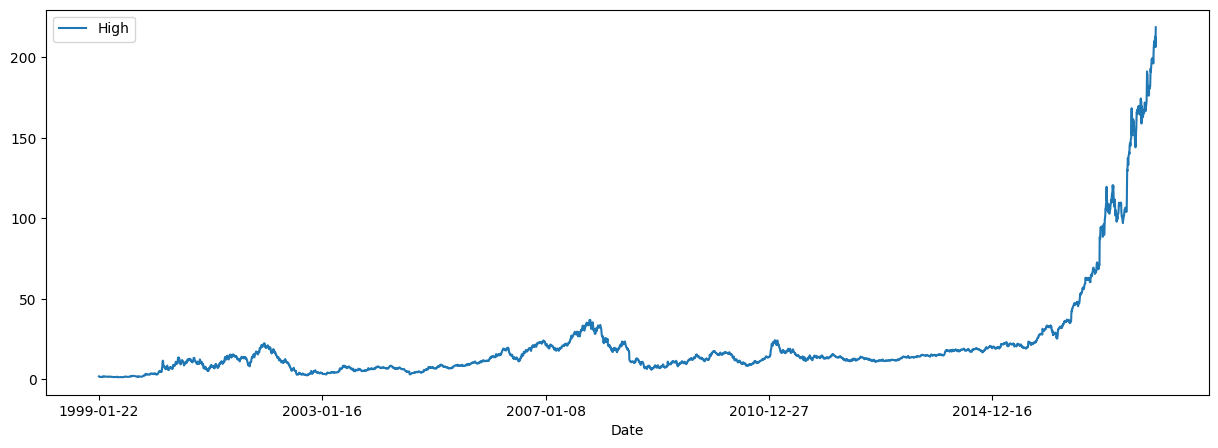

In [6]:
plot = df.plot('Date', 'High', figsize=(15, 5))

In [7]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4733 entries, 0 to 4732
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     4733 non-null   object 
 1   Open     4733 non-null   float64
 2   High     4733 non-null   float64
 3   Low      4733 non-null   float64
 4   Close    4733 non-null   float64
 5   Volume   4733 non-null   int64  
 6   OpenInt  4733 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 259.0+ KB


In [9]:
# checking for null values
df.isnull().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

In [10]:
df = df.dropna()

In [11]:
df.shape

(4733, 7)

In [12]:
df.describe()

,Open,High,Low,Close,Volume,OpenInt
count,4733.000000,4733.000000,4733.000000,4733.000000,4.733000e+03,4733.0
mean,20.796242,21.157332,20.420417,20.805404,1.615287e+07,0.0
std,30.236284,30.615622,29.792958,30.263705,1.272446e+07,0.0
min,1.298900,1.317500,1.233900,1.261900,0.000000e+00,0.0
25%,7.988300,8.247900,7.756400,7.978900,8.181100e+06,0.0
50%,12.963000,13.238000,12.721000,12.990000,1.390271e+07,0.0
75%,19.141000,19.418000,18.778000,19.106000,2.051602e+07,0.0
max,213.080000,218.670000,211.630000,216.140000,2.496659e+08,0.0


#### Converting the DataFrame to a NumPy Array

In [13]:
def create_sequences(input_data, output_data, window_size, step):
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)

In [14]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Select features
features = df[['Open', 'High', 'Low', 'Close']]
labels = df['High'].shift(-1)  # Next day's high price as label

X, y = create_sequences(features, labels, window_size=10, step=15)

print(f'Shape of data X: {X.shape}')
print(f'Shape of data y: {y.shape}')

# split the hold-out tests
ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int) # 10% hold-out
x_test = X[ind]
y_test = y[ind]
all_ind = np.arange(len(X))
remains_ind = np.delete(all_ind, ind)

X = X[remains_ind]
y = y[remains_ind]

# shuffle dataset
ind = np.random.permutation(len(X))
X = X[ind]
y = y[ind]
split_point = int(X.shape[0]*0.8)

x_train = X[:split_point]
y_train = y[:split_point]
x_val = X[split_point:]
y_val = y[split_point:]

print(f'Shape of data x_train: {x_train.shape}')
print(f'Shape of data y_train: {y_train.shape}')
print(f'Shape of data x_val: {x_val.shape}')
print(f'Shape of data y_val: {y_val.shape}')
print(f'Shape of data x_test: {x_test.shape}')
print(f'Shape of data y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')

Shape of data X: (315, 10, 4)
Shape of data y: (315,)
Shape of data x_train: (227, 10, 4)
Shape of data y_train: (227,)
Shape of data x_val: (57, 10, 4)
Shape of data y_val: (57,)
Shape of data x_test: (31, 10, 4)
Shape of data y_test: (31,)
Number of samples in training and validation are 227 and 57.


## B. Defining Neural Networks

In [15]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

## C. Training the Neural Network

In [16]:
# Check your GPU status.
!nvidia-smi

'nvidia-smi' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC


In [18]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []

epochs = 100

model = LSTMModel(input_dim=4, hidden_dim=500, num_layers=2, output_dim=1)
print(model)

best_val_loss = float('inf')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features = features
        labels = labels
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning rate update
    lr_scheduler.step()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for features, labels in val_loader:
            features = features
            labels = labels
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')

    # Store performance
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

LSTMModel(
  (lstm): LSTM(4, 500, num_layers=2, batch_first=True)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


  1%|          | 1/100 [00:00<01:38,  1.00it/s]

Epoch 1/100, Train loss: 1205.2660, Val loss: 491.6276, Best Val loss: 491.6276


  2%|▏         | 2/100 [00:01<00:54,  1.81it/s]

Epoch 2/100, Train loss: 891.5231, Val loss: 465.1647, Best Val loss: 465.1647


  4%|▍         | 4/100 [00:01<00:30,  3.16it/s]

Epoch 3/100, Train loss: 858.4551, Val loss: 466.5057, Best Val loss: 465.1647
Epoch 4/100, Train loss: 841.4462, Val loss: 473.3278, Best Val loss: 465.1647


  5%|▌         | 5/100 [00:01<00:27,  3.50it/s]

Epoch 5/100, Train loss: 843.1738, Val loss: 481.0121, Best Val loss: 465.1647


  6%|▌         | 6/100 [00:02<00:24,  3.89it/s]

Epoch 6/100, Train loss: 1026.4683, Val loss: 481.5229, Best Val loss: 465.1647


  7%|▋         | 7/100 [00:02<00:24,  3.85it/s]

Epoch 7/100, Train loss: 843.9504, Val loss: 488.0946, Best Val loss: 465.1647


  8%|▊         | 8/100 [00:02<00:23,  3.84it/s]

Epoch 8/100, Train loss: 852.0040, Val loss: 483.9701, Best Val loss: 465.1647


  9%|▉         | 9/100 [00:02<00:24,  3.78it/s]

Epoch 9/100, Train loss: 862.1683, Val loss: 477.7355, Best Val loss: 465.1647


 10%|█         | 10/100 [00:03<00:22,  3.94it/s]

Epoch 10/100, Train loss: 836.7242, Val loss: 474.4918, Best Val loss: 465.1647


 11%|█         | 11/100 [00:03<00:22,  4.04it/s]

Epoch 11/100, Train loss: 1586.1107, Val loss: 470.7868, Best Val loss: 465.1647


 12%|█▏        | 12/100 [00:03<00:21,  4.03it/s]

Epoch 12/100, Train loss: 845.8093, Val loss: 478.4155, Best Val loss: 465.1647


 13%|█▎        | 13/100 [00:03<00:21,  4.04it/s]

Epoch 13/100, Train loss: 1466.9978, Val loss: 480.2915, Best Val loss: 465.1647


 14%|█▍        | 14/100 [00:04<00:21,  4.07it/s]

Epoch 14/100, Train loss: 833.5380, Val loss: 491.5904, Best Val loss: 465.1647


 15%|█▌        | 15/100 [00:04<00:21,  3.96it/s]

Epoch 15/100, Train loss: 830.6191, Val loss: 488.4045, Best Val loss: 465.1647


 16%|█▌        | 16/100 [00:04<00:20,  4.16it/s]

Epoch 16/100, Train loss: 825.3093, Val loss: 476.6661, Best Val loss: 465.1647


 17%|█▋        | 17/100 [00:04<00:19,  4.16it/s]

Epoch 17/100, Train loss: 894.3998, Val loss: 463.2609, Best Val loss: 463.2609


 18%|█▊        | 18/100 [00:05<00:19,  4.20it/s]

Epoch 18/100, Train loss: 816.6962, Val loss: 452.5674, Best Val loss: 452.5674


 19%|█▉        | 19/100 [00:05<00:18,  4.35it/s]

Epoch 19/100, Train loss: 808.2113, Val loss: 440.3142, Best Val loss: 440.3142


 20%|██        | 20/100 [00:05<00:18,  4.41it/s]

Epoch 20/100, Train loss: 797.7039, Val loss: 428.8932, Best Val loss: 428.8932


 21%|██        | 21/100 [00:05<00:17,  4.44it/s]

Epoch 21/100, Train loss: 1104.1872, Val loss: 416.8185, Best Val loss: 416.8185


 22%|██▏       | 22/100 [00:05<00:17,  4.48it/s]

Epoch 22/100, Train loss: 752.1168, Val loss: 334.6789, Best Val loss: 334.6789


 23%|██▎       | 23/100 [00:06<00:17,  4.46it/s]

Epoch 23/100, Train loss: 690.9544, Val loss: 312.4054, Best Val loss: 312.4054


 24%|██▍       | 24/100 [00:06<00:17,  4.37it/s]

Epoch 24/100, Train loss: 715.1247, Val loss: 294.2412, Best Val loss: 294.2412


 25%|██▌       | 25/100 [00:06<00:16,  4.44it/s]

Epoch 25/100, Train loss: 1374.0106, Val loss: 268.5296, Best Val loss: 268.5296


 26%|██▌       | 26/100 [00:06<00:16,  4.43it/s]

Epoch 26/100, Train loss: 1303.9460, Val loss: 242.4762, Best Val loss: 242.4762


 27%|██▋       | 27/100 [00:07<00:16,  4.37it/s]

Epoch 27/100, Train loss: 552.8172, Val loss: 219.3760, Best Val loss: 219.3760


 28%|██▊       | 28/100 [00:07<00:16,  4.36it/s]

Epoch 28/100, Train loss: 526.2272, Val loss: 203.7236, Best Val loss: 203.7236


 29%|██▉       | 29/100 [00:07<00:16,  4.40it/s]

Epoch 29/100, Train loss: 502.6628, Val loss: 190.5848, Best Val loss: 190.5848


 30%|███       | 30/100 [00:07<00:15,  4.44it/s]

Epoch 30/100, Train loss: 481.1757, Val loss: 179.7874, Best Val loss: 179.7874


 31%|███       | 31/100 [00:07<00:15,  4.36it/s]

Epoch 31/100, Train loss: 567.3641, Val loss: 169.0372, Best Val loss: 169.0372


 32%|███▏      | 32/100 [00:08<00:15,  4.31it/s]

Epoch 32/100, Train loss: 1295.0873, Val loss: 156.8640, Best Val loss: 156.8640


 33%|███▎      | 33/100 [00:08<00:15,  4.20it/s]

Epoch 33/100, Train loss: 427.4955, Val loss: 142.3006, Best Val loss: 142.3006


 34%|███▍      | 34/100 [00:08<00:15,  4.30it/s]

Epoch 34/100, Train loss: 407.2954, Val loss: 133.4254, Best Val loss: 133.4254


 35%|███▌      | 35/100 [00:08<00:14,  4.36it/s]

Epoch 35/100, Train loss: 391.1432, Val loss: 125.1131, Best Val loss: 125.1131


 36%|███▌      | 36/100 [00:09<00:14,  4.41it/s]

Epoch 36/100, Train loss: 378.8200, Val loss: 118.1832, Best Val loss: 118.1832


 37%|███▋      | 37/100 [00:09<00:14,  4.44it/s]

Epoch 37/100, Train loss: 368.8104, Val loss: 112.8294, Best Val loss: 112.8294


 38%|███▊      | 38/100 [00:09<00:13,  4.48it/s]

Epoch 38/100, Train loss: 359.3485, Val loss: 108.0475, Best Val loss: 108.0475


 39%|███▉      | 39/100 [00:09<00:13,  4.43it/s]

Epoch 39/100, Train loss: 349.4963, Val loss: 102.9627, Best Val loss: 102.9627


 40%|████      | 40/100 [00:10<00:13,  4.29it/s]

Epoch 40/100, Train loss: 342.1460, Val loss: 98.2201, Best Val loss: 98.2201


 41%|████      | 41/100 [00:10<00:13,  4.29it/s]

Epoch 41/100, Train loss: 334.0221, Val loss: 93.7751, Best Val loss: 93.7751


 42%|████▏     | 42/100 [00:10<00:13,  4.20it/s]

Epoch 42/100, Train loss: 326.6275, Val loss: 89.0121, Best Val loss: 89.0121


 43%|████▎     | 43/100 [00:10<00:13,  4.13it/s]

Epoch 43/100, Train loss: 318.2893, Val loss: 85.2458, Best Val loss: 85.2458


 44%|████▍     | 44/100 [00:11<00:15,  3.71it/s]

Epoch 44/100, Train loss: 662.3884, Val loss: 81.0948, Best Val loss: 81.0948


 45%|████▌     | 45/100 [00:11<00:16,  3.42it/s]

Epoch 45/100, Train loss: 356.0511, Val loss: 75.7609, Best Val loss: 75.7609


 46%|████▌     | 46/100 [00:11<00:16,  3.18it/s]

Epoch 46/100, Train loss: 294.0325, Val loss: 71.1873, Best Val loss: 71.1873


 47%|████▋     | 47/100 [00:12<00:18,  2.81it/s]

Epoch 47/100, Train loss: 286.1019, Val loss: 67.6890, Best Val loss: 67.6890


 48%|████▊     | 48/100 [00:12<00:20,  2.54it/s]

Epoch 48/100, Train loss: 280.8062, Val loss: 64.6070, Best Val loss: 64.6070


 49%|████▉     | 49/100 [00:13<00:21,  2.35it/s]

Epoch 49/100, Train loss: 274.8697, Val loss: 61.8069, Best Val loss: 61.8069


 50%|█████     | 50/100 [00:13<00:21,  2.28it/s]

Epoch 50/100, Train loss: 269.0887, Val loss: 60.8068, Best Val loss: 60.8068


 51%|█████     | 51/100 [00:14<00:21,  2.27it/s]

Epoch 51/100, Train loss: 574.8810, Val loss: 58.3632, Best Val loss: 58.3632


 52%|█████▏    | 52/100 [00:14<00:21,  2.21it/s]

Epoch 52/100, Train loss: 258.5599, Val loss: 55.1616, Best Val loss: 55.1616


 53%|█████▎    | 53/100 [00:15<00:21,  2.16it/s]

Epoch 53/100, Train loss: 252.3486, Val loss: 54.5626, Best Val loss: 54.5626


 54%|█████▍    | 54/100 [00:15<00:22,  2.08it/s]

Epoch 54/100, Train loss: 247.2655, Val loss: 52.1772, Best Val loss: 52.1772


 55%|█████▌    | 55/100 [00:16<00:22,  2.04it/s]

Epoch 55/100, Train loss: 242.7221, Val loss: 49.7911, Best Val loss: 49.7911


 56%|█████▌    | 56/100 [00:16<00:21,  2.07it/s]

Epoch 56/100, Train loss: 239.1176, Val loss: 48.2891, Best Val loss: 48.2891


 57%|█████▋    | 57/100 [00:17<00:20,  2.12it/s]

Epoch 57/100, Train loss: 417.8370, Val loss: 46.1947, Best Val loss: 46.1947


 58%|█████▊    | 58/100 [00:17<00:19,  2.17it/s]

Epoch 58/100, Train loss: 571.8834, Val loss: 44.1815, Best Val loss: 44.1815


 59%|█████▉    | 59/100 [00:17<00:18,  2.18it/s]

Epoch 59/100, Train loss: 226.3209, Val loss: 42.6383, Best Val loss: 42.6383


 60%|██████    | 60/100 [00:18<00:18,  2.14it/s]

Epoch 60/100, Train loss: 390.1386, Val loss: 42.0484, Best Val loss: 42.0484


 61%|██████    | 61/100 [00:18<00:17,  2.22it/s]

Epoch 61/100, Train loss: 217.4615, Val loss: 46.1111, Best Val loss: 42.0484


 62%|██████▏   | 62/100 [00:19<00:16,  2.27it/s]

Epoch 62/100, Train loss: 213.7355, Val loss: 43.6318, Best Val loss: 42.0484


 63%|██████▎   | 63/100 [00:19<00:16,  2.31it/s]

Epoch 63/100, Train loss: 210.7532, Val loss: 41.7679, Best Val loss: 41.7679


 64%|██████▍   | 64/100 [00:20<00:16,  2.22it/s]

Epoch 64/100, Train loss: 207.9240, Val loss: 40.5504, Best Val loss: 40.5504


 65%|██████▌   | 65/100 [00:20<00:15,  2.20it/s]

Epoch 65/100, Train loss: 205.7113, Val loss: 39.6195, Best Val loss: 39.6195


 66%|██████▌   | 66/100 [00:21<00:15,  2.23it/s]

Epoch 66/100, Train loss: 203.5271, Val loss: 38.6691, Best Val loss: 38.6691


 67%|██████▋   | 67/100 [00:21<00:14,  2.24it/s]

Epoch 67/100, Train loss: 201.8486, Val loss: 37.7743, Best Val loss: 37.7743


 68%|██████▊   | 68/100 [00:21<00:14,  2.25it/s]

Epoch 68/100, Train loss: 199.6427, Val loss: 37.1966, Best Val loss: 37.1966


 69%|██████▉   | 69/100 [00:22<00:13,  2.30it/s]

Epoch 69/100, Train loss: 197.9102, Val loss: 36.5194, Best Val loss: 36.5194


 70%|███████   | 70/100 [00:22<00:13,  2.27it/s]

Epoch 70/100, Train loss: 196.6772, Val loss: 36.2065, Best Val loss: 36.2065


 71%|███████   | 71/100 [00:23<00:12,  2.32it/s]

Epoch 71/100, Train loss: 195.0469, Val loss: 37.4289, Best Val loss: 36.2065


 72%|███████▏  | 72/100 [00:23<00:11,  2.42it/s]

Epoch 72/100, Train loss: 193.5452, Val loss: 36.0482, Best Val loss: 36.0482


 73%|███████▎  | 73/100 [00:24<00:11,  2.40it/s]

Epoch 73/100, Train loss: 445.2230, Val loss: 34.7655, Best Val loss: 34.7655


 74%|███████▍  | 74/100 [00:24<00:10,  2.48it/s]

Epoch 74/100, Train loss: 190.5302, Val loss: 33.2555, Best Val loss: 33.2555


 75%|███████▌  | 75/100 [00:24<00:09,  2.51it/s]

Epoch 75/100, Train loss: 188.8416, Val loss: 32.3518, Best Val loss: 32.3518


 76%|███████▌  | 76/100 [00:25<00:09,  2.51it/s]

Epoch 76/100, Train loss: 187.4596, Val loss: 31.8833, Best Val loss: 31.8833


 77%|███████▋  | 77/100 [00:25<00:09,  2.48it/s]

Epoch 77/100, Train loss: 186.2890, Val loss: 31.4108, Best Val loss: 31.4108


 78%|███████▊  | 78/100 [00:26<00:08,  2.48it/s]

Epoch 78/100, Train loss: 185.3460, Val loss: 31.0341, Best Val loss: 31.0341


 79%|███████▉  | 79/100 [00:26<00:08,  2.43it/s]

Epoch 79/100, Train loss: 184.6531, Val loss: 30.5402, Best Val loss: 30.5402


 80%|████████  | 80/100 [00:26<00:08,  2.38it/s]

Epoch 80/100, Train loss: 183.7467, Val loss: 30.2804, Best Val loss: 30.2804


 81%|████████  | 81/100 [00:27<00:07,  2.41it/s]

Epoch 81/100, Train loss: 183.1334, Val loss: 30.0081, Best Val loss: 30.0081


 82%|████████▏ | 82/100 [00:27<00:07,  2.44it/s]

Epoch 82/100, Train loss: 182.4644, Val loss: 29.7143, Best Val loss: 29.7143


 83%|████████▎ | 83/100 [00:28<00:07,  2.38it/s]

Epoch 83/100, Train loss: 181.9559, Val loss: 29.3558, Best Val loss: 29.3558


 84%|████████▍ | 84/100 [00:28<00:06,  2.40it/s]

Epoch 84/100, Train loss: 181.3398, Val loss: 29.1738, Best Val loss: 29.1738


 85%|████████▌ | 85/100 [00:28<00:06,  2.43it/s]

Epoch 85/100, Train loss: 180.9281, Val loss: 29.0685, Best Val loss: 29.0685


 86%|████████▌ | 86/100 [00:29<00:05,  2.40it/s]

Epoch 86/100, Train loss: 180.5671, Val loss: 28.9223, Best Val loss: 28.9223


 87%|████████▋ | 87/100 [00:29<00:05,  2.45it/s]

Epoch 87/100, Train loss: 180.1603, Val loss: 28.7296, Best Val loss: 28.7296


 88%|████████▊ | 88/100 [00:30<00:04,  2.49it/s]

Epoch 88/100, Train loss: 179.7821, Val loss: 28.5963, Best Val loss: 28.5963


 89%|████████▉ | 89/100 [00:30<00:04,  2.52it/s]

Epoch 89/100, Train loss: 179.4593, Val loss: 28.4787, Best Val loss: 28.4787


 90%|█████████ | 90/100 [00:31<00:04,  2.34it/s]

Epoch 90/100, Train loss: 179.2589, Val loss: 28.3862, Best Val loss: 28.3862


 91%|█████████ | 91/100 [00:31<00:03,  2.31it/s]

Epoch 91/100, Train loss: 179.0834, Val loss: 28.2883, Best Val loss: 28.2883


 92%|█████████▏| 92/100 [00:31<00:03,  2.38it/s]

Epoch 92/100, Train loss: 178.8764, Val loss: 28.2338, Best Val loss: 28.2338


 93%|█████████▎| 93/100 [00:32<00:02,  2.44it/s]

Epoch 93/100, Train loss: 178.7574, Val loss: 28.1938, Best Val loss: 28.1938


 94%|█████████▍| 94/100 [00:32<00:02,  2.46it/s]

Epoch 94/100, Train loss: 178.7103, Val loss: 28.1594, Best Val loss: 28.1594


 95%|█████████▌| 95/100 [00:33<00:01,  2.50it/s]

Epoch 95/100, Train loss: 178.5774, Val loss: 28.1230, Best Val loss: 28.1230


 96%|█████████▌| 96/100 [00:33<00:01,  2.46it/s]

Epoch 96/100, Train loss: 178.5149, Val loss: 28.1116, Best Val loss: 28.1116


 97%|█████████▋| 97/100 [00:33<00:01,  2.47it/s]

Epoch 97/100, Train loss: 178.5187, Val loss: 28.1022, Best Val loss: 28.1022


 98%|█████████▊| 98/100 [00:34<00:00,  2.45it/s]

Epoch 98/100, Train loss: 178.4564, Val loss: 28.0944, Best Val loss: 28.0944


 99%|█████████▉| 99/100 [00:34<00:00,  2.50it/s]

Epoch 99/100, Train loss: 178.4365, Val loss: 28.0919, Best Val loss: 28.0919


100%|██████████| 100/100 [00:35<00:00,  2.85it/s]

Epoch 100/100, Train loss: 178.4548, Val loss: 28.0911, Best Val loss: 28.0911


#### Visualizing the model performance

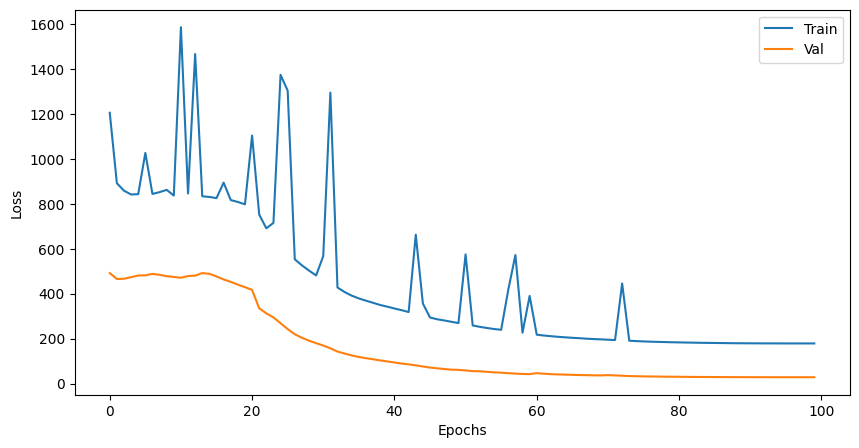

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

In [21]:
# Load the trained weights
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

pred_value = []
actual_value = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features
        outputs = model(features).squeeze(-1)
        pred_value.append(outputs.cpu())
        actual_value.append(labels)

pred_value = torch.cat(pred_value)
actual_value = torch.cat(actual_value)

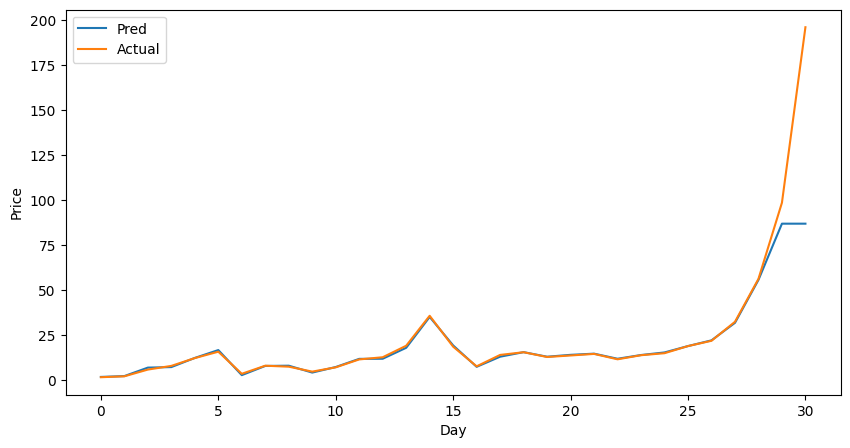

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(pred_value[:])
plt.plot(actual_value[:])
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Pred', 'Actual'])

plt.show()

In [23]:
#1. 資料載入 + 切 train/val/test

import pandas as pd
import numpy as np

# 讀取資料
df = pd.read_csv(r"C:\Users\eason\OneDrive\桌面\HW4\nvda.us.txt")


close_prices = df['Close'].values

# Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
close_prices = scaler.fit_transform(close_prices.reshape(-1, 1)).flatten()

# 切分
n_total = len(close_prices)
n_train = int(n_total * 0.8)
n_val = int(n_total * 0.1)

train_data = close_prices[:n_train]
val_data = close_prices[n_train:n_train+n_val]
test_data = close_prices[n_train+n_val:]

#2. 切 window 的 function
import torch
from torch.utils.data import DataLoader, TensorDataset

def create_dataloader(data, window_size, step_size, batch_size=64):
    features = []
    labels = []

    for i in range(0, len(data) - window_size, step_size):
        x = data[i:i+window_size]
        y = data[i+window_size]
        features.append(x)
        labels.append(y)

    features = torch.tensor(features, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32)

    dataset = TensorDataset(features, labels)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return loader

#3. 訓練和評估的 function
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # input: (batch, seq_len) → (batch, seq_len, 1)
        x = x.unsqueeze(-1)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

def train_and_evaluate(train_loader, val_loader, input_dim=1, hidden_dim=500, num_layers=2, output_dim=1, epochs=100):
    model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        for features, labels in train_loader:
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for features, labels in val_loader:
                outputs = model(features).squeeze(-1)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss

        lr_scheduler.step()

    return best_val_loss

#4. 三組組合實驗 & 結果整理
settings = [(20,5), (30,5), (40,10)]
results = []

for window_size, step_size in settings:
    print(f'Running with Window Size {window_size} and Step Size {step_size}...')
    train_loader = create_dataloader(train_data, window_size, step_size)
    val_loader = create_dataloader(val_data, window_size, step_size)

    best_val_loss = train_and_evaluate(train_loader, val_loader)
    results.append((window_size, step_size, best_val_loss))

print("\n=== Summary ===")
for r in results:
    print(f"Window size: {r[0]}, Step size: {r[1]}, Best Validation MSE: {r[2]:.4f}")




Running with Window Size 20 and Step Size 5...


C:\Users\eason\AppData\Local\Temp\ipykernel_20416\3825576301.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  features = torch.tensor(features, dtype=torch.float32)


Running with Window Size 30 and Step Size 5...
Running with Window Size 40 and Step Size 10...

=== Summary ===
Window size: 20, Step size: 5, Best Validation MSE: 0.0000
Window size: 30, Step size: 5, Best Validation MSE: 0.0000
Window size: 40, Step size: 10, Best Validation MSE: 0.0000


In [24]:
import pandas as pd

# 建表
summary_df = pd.DataFrame(results, columns=["Window Size", "Step Size", "Best Validation MSE"])
print(summary_df)


   Window Size  Step Size  Best Validation MSE
0           20          5             0.000007
1           30          5             0.000008
2           40         10             0.000008


In [26]:
# # 1. 讀資料＋Normalize 多個欄位
# # 讀取資料
# df = pd.read_csv(r"C:\Users\eason\OneDrive\桌面\HW4\nvda.us.txt")

# # 取出 Close 和 Volume 欄位
# data = df[['Close', 'Volume']].values

# # Normalization
# scaler = MinMaxScaler()
# data = scaler.fit_transform(data)

# # 切分
# n_total = len(data)
# n_train = int(n_total * 0.8)
# n_val = int(n_total * 0.1)

# train_data = data[:n_train]
# val_data = data[n_train:n_train+n_val]
# test_data = data[n_train+n_val:]

# # 2.改 create_dataloader(讓每個 feature 是多維）
# def create_dataloader(data, window_size, step_size, batch_size=64):
#     features = []
#     labels = []

#     for i in range(0, len(data) - window_size, step_size):
#         x = data[i:i+window_size]
#         y = data[i+window_size, 0]  # 預測 Close 價（第0欄）
#         features.append(x)
#         labels.append(y)

#     features = torch.tensor(np.array(features), dtype=torch.float32)
#     labels = torch.tensor(np.array(labels), dtype=torch.float32)

#     dataset = TensorDataset(features, labels)
#     loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#     return loader
# # 3.小改模型 forward，因為我們現在 feature 數已經 >1，不用再 unsqueeze了
# def forward(self, x):
#     out, _ = self.lstm(x)
#     out = out[:, -1, :]
#     out = self.fc(out)
#     return out

# 1. 讀資料 + Normalize 多個欄位
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# 讀取資料
df = pd.read_csv(r"C:\Users\eason\OneDrive\桌面\HW4\nvda.us.txt")

# 取出 Close 和 Volume 欄位
data = df[['Close', 'Volume']].values

# Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# 切分
n_total = len(data)
n_train = int(n_total * 0.8)
n_val = int(n_total * 0.1)

train_data = data[:n_train]
val_data = data[n_train:n_train+n_val]
test_data = data[n_train+n_val:]

# 2. 切 window 的 function（多特徵版）
def create_dataloader(data, window_size, step_size, batch_size=64):
    features = []
    labels = []

    for i in range(0, len(data) - window_size, step_size):
        x = data[i:i+window_size]
        y = data[i+window_size, 0]  # 只預測 Close 價（第0欄）
        features.append(x)
        labels.append(y)

    features = torch.tensor(np.array(features), dtype=torch.float32)
    labels = torch.tensor(np.array(labels), dtype=torch.float32)

    dataset = TensorDataset(features, labels)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return loader

# 3. 訓練和評估的 function（小改 forward）
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # input: (batch, seq_len, input_dim) already OK
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

def train_and_evaluate(train_loader, val_loader, input_dim, hidden_dim=500, num_layers=2, output_dim=1, epochs=100):
    model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        for features, labels in train_loader:
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for features, labels in val_loader:
                outputs = model(features).squeeze(-1)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss

        lr_scheduler.step()

    return best_val_loss

# 4. 三組組合實驗 & 結果整理
settings = [(20,5), (30,5), (40,10)]
results = []

input_dim = train_data.shape[1]  # <- 加這行是因為現在有兩個 feature

for window_size, step_size in settings:
    print(f'Running with Window Size {window_size} and Step Size {step_size}...')
    train_loader = create_dataloader(train_data, window_size, step_size)
    val_loader = create_dataloader(val_data, window_size, step_size)

    best_val_loss = train_and_evaluate(train_loader, val_loader, input_dim=input_dim)
    results.append((window_size, step_size, best_val_loss))

print("\n=== Summary ===")
for r in results:
    print(f"Window size: {r[0]}, Step size: {r[1]}, Best Validation MSE: {r[2]:.6f}")





Running with Window Size 20 and Step Size 5...
Running with Window Size 30 and Step Size 5...
Running with Window Size 40 and Step Size 10...

=== Summary ===
Window size: 20, Step size: 5, Best Validation MSE: 0.000008
Window size: 30, Step size: 5, Best Validation MSE: 0.000007
Window size: 40, Step size: 10, Best Validation MSE: 0.000009


In [29]:

import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.preprocessing import MinMaxScaler

# 1. 切 window function
def create_dataloader(data, window_size, step_size, batch_size=64, target_col=0):
    features = []
    labels = []
    for i in range(0, len(data) - window_size, step_size):
        x = data[i:i+window_size]
        y = data[i+window_size, target_col]  # 用 target_col 決定預測哪一個欄
        features.append(x)
        labels.append(y)
    features = torch.tensor(np.array(features), dtype=torch.float32)
    labels = torch.tensor(np.array(labels), dtype=torch.float32)
    dataset = TensorDataset(features, labels)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader


# 2. 模型和訓練 function
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

def train_and_evaluate(train_loader, val_loader, input_dim, hidden_dim=500, num_layers=2, output_dim=1, epochs=100):
    model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        for features, labels in train_loader:
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for features, labels in val_loader:
                outputs = model(features).squeeze(-1)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
        lr_scheduler.step()
    return best_val_loss

# 3. 特徵組合設定
feature_sets = {
    "Close Only": ['Close'],
    "Close + Volume": ['Close', 'Volume'],
    "Open+High+Low+Close": ['Open', 'High', 'Low', 'Close'],
    "All Features": ['Open', 'High', 'Low', 'Close', 'Volume']
}

# 4. 進行多組特徵實驗
settings = [(30,5)]  # 固定一組 (window_size, step_size) 來比較公平，所以這裡選擇一組
results = []

for feature_name, feature_list in feature_sets.items():
    print(f"\n=== Running Feature Set: {feature_name} ===")

    # 讀資料
    df = pd.read_csv(r"C:\Users\eason\OneDrive\桌面\HW4\nvda.us.txt")
    data = df[feature_list].values

    # Normalize
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    # 切分
    n_total = len(data)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    train_data = data[:n_train]
    val_data = data[n_train:n_train+n_val]
    test_data = data[n_train+n_val:]

    input_dim = train_data.shape[1]

target_col = feature_list.index('Close')  # 找到 'Close' 是第幾個欄

for window_size, step_size in settings:
    train_loader = create_dataloader(train_data, window_size, step_size, target_col=target_col)
    val_loader = create_dataloader(val_data, window_size, step_size, target_col=target_col)

    best_val_loss = train_and_evaluate(train_loader, val_loader, input_dim=input_dim)
    results.append((feature_name, window_size, step_size, best_val_loss))


# 5. 結果整理
print("\n=== Summary ===")
for r in results:
    print(f"Feature set: {r[0]}, Window size: {r[1]}, Step size: {r[2]}, Best Validation MSE: {r[3]:.6f}")



=== Running Feature Set: Close Only ===

=== Running Feature Set: Close + Volume ===

=== Running Feature Set: Open+High+Low+Close ===

=== Running Feature Set: All Features ===

=== Summary ===
Feature set: All Features, Window size: 30, Step size: 5, Best Validation MSE: 0.000006


In [30]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.preprocessing import MinMaxScaler

# 1. 切 window function
def create_dataloader(data, window_size, step_size, batch_size=64, target_col=0):
    features = []
    labels = []
    for i in range(0, len(data) - window_size, step_size):
        x = data[i:i+window_size]
        y = data[i+window_size, target_col]
        features.append(x)
        labels.append(y)
    features = torch.tensor(np.array(features), dtype=torch.float32)
    labels = torch.tensor(np.array(labels), dtype=torch.float32)
    dataset = TensorDataset(features, labels)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

# 2. 模型和訓練 function
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

def train_and_evaluate(train_loader, val_loader, input_dim, hidden_dim=500, num_layers=2, output_dim=1, epochs=100):
    model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        for features, labels in train_loader:
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for features, labels in val_loader:
                outputs = model(features).squeeze(-1)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
        lr_scheduler.step()
    return best_val_loss

# 3. 特徵組合設定
feature_sets = {
    "Close Only": ['Close'],
    "Close + Volume": ['Close', 'Volume'],
    "Open+High+Low+Close": ['Open', 'High', 'Low', 'Close'],
    "All Features": ['Open', 'High', 'Low', 'Close', 'Volume']
}

# 4. 設定是否使用 normalization
normalized = True  # 設為 False 就是不做 normalization

# 5. 固定 window/step 組合
settings = [(30, 5)]
results = []

for feature_name, feature_list in feature_sets.items():
    print(f"\n=== Running Feature Set: {feature_name} (Normalized: {normalized}) ===")
    
    df = pd.read_csv(r"C:\Users\eason\OneDrive\桌面\HW4\nvda.us.txt")
    data = df[feature_list].values

    # Normalize or not
    if normalized:
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)
    else:
        data = np.array(data, dtype=np.float32)  # 保留原始數值

    # 切分資料
    n_total = len(data)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    train_data = data[:n_train]
    val_data = data[n_train:n_train+n_val]
    test_data = data[n_train+n_val:]

    input_dim = train_data.shape[1]
    target_col = feature_list.index('Close')  # 預測 'Close'

    for window_size, step_size in settings:
        train_loader = create_dataloader(train_data, window_size, step_size, target_col=target_col)
        val_loader = create_dataloader(val_data, window_size, step_size, target_col=target_col)
        best_val_loss = train_and_evaluate(train_loader, val_loader, input_dim=input_dim)
        results.append((feature_name, normalized, window_size, step_size, best_val_loss))

# 6. 結果輸出
print("\n=== Summary ===")
for r in results:
    print(f"Feature set: {r[0]}, Normalized: {r[1]}, Window size: {r[2]}, Step size: {r[3]}, Best Validation MSE: {r[4]:.6f}")




=== Running Feature Set: Close Only (Normalized: True) ===

=== Running Feature Set: Close + Volume (Normalized: True) ===

=== Running Feature Set: Open+High+Low+Close (Normalized: True) ===

=== Running Feature Set: All Features (Normalized: True) ===

=== Summary ===
Feature set: Close Only, Normalized: True, Window size: 30, Step size: 5, Best Validation MSE: 0.000007
Feature set: Close + Volume, Normalized: True, Window size: 30, Step size: 5, Best Validation MSE: 0.000007
Feature set: Open+High+Low+Close, Normalized: True, Window size: 30, Step size: 5, Best Validation MSE: 0.000006
Feature set: All Features, Normalized: True, Window size: 30, Step size: 5, Best Validation MSE: 0.000006


In [31]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.preprocessing import MinMaxScaler

# 1. 切 window function
def create_dataloader(data, window_size, step_size, batch_size=64, target_col=0):
    features = []
    labels = []
    for i in range(0, len(data) - window_size, step_size):
        x = data[i:i+window_size]
        y = data[i+window_size, target_col]
        features.append(x)
        labels.append(y)
    features = torch.tensor(np.array(features), dtype=torch.float32)
    labels = torch.tensor(np.array(labels), dtype=torch.float32)
    dataset = TensorDataset(features, labels)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

# 2. 模型和訓練 function
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

def train_and_evaluate(train_loader, val_loader, input_dim, hidden_dim=500, num_layers=2, output_dim=1, epochs=100):
    model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        for features, labels in train_loader:
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for features, labels in val_loader:
                outputs = model(features).squeeze(-1)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
        lr_scheduler.step()
    return best_val_loss

# 3. 特徵組合設定
feature_sets = {
    "Close Only": ['Close'],
    "Close + Volume": ['Close', 'Volume'],
    "Open+High+Low+Close": ['Open', 'High', 'Low', 'Close'],
    "All Features": ['Open', 'High', 'Low', 'Close', 'Volume']
}

# 4. 設定是否使用 normalization
normalized = False  # 設為 False 就是不做 normalization

# 5. 固定 window/step 組合
settings = [(30, 5)]
results = []

for feature_name, feature_list in feature_sets.items():
    print(f"\n=== Running Feature Set: {feature_name} (Normalized: {normalized}) ===")
    
    df = pd.read_csv(r"C:\Users\eason\OneDrive\桌面\HW4\nvda.us.txt")
    data = df[feature_list].values

    # Normalize or not
    if normalized:
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)
    else:
        data = np.array(data, dtype=np.float32)  # 保留原始數值

    # 切分資料
    n_total = len(data)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    train_data = data[:n_train]
    val_data = data[n_train:n_train+n_val]
    test_data = data[n_train+n_val:]

    input_dim = train_data.shape[1]
    target_col = feature_list.index('Close')  # 預測 'Close'

    for window_size, step_size in settings:
        train_loader = create_dataloader(train_data, window_size, step_size, target_col=target_col)
        val_loader = create_dataloader(val_data, window_size, step_size, target_col=target_col)
        best_val_loss = train_and_evaluate(train_loader, val_loader, input_dim=input_dim)
        results.append((feature_name, normalized, window_size, step_size, best_val_loss))

# 6. 結果輸出
print("\n=== Summary ===")
for r in results:
    print(f"Feature set: {r[0]}, Normalized: {r[1]}, Window size: {r[2]}, Step size: {r[3]}, Best Validation MSE: {r[4]:.6f}")



=== Running Feature Set: Close Only (Normalized: False) ===

=== Running Feature Set: Close + Volume (Normalized: False) ===

=== Running Feature Set: Open+High+Low+Close (Normalized: False) ===

=== Running Feature Set: All Features (Normalized: False) ===

=== Summary ===
Feature set: Close Only, Normalized: False, Window size: 30, Step size: 5, Best Validation MSE: 0.139164
Feature set: Close + Volume, Normalized: False, Window size: 30, Step size: 5, Best Validation MSE: 76.822819
Feature set: Open+High+Low+Close, Normalized: False, Window size: 30, Step size: 5, Best Validation MSE: 0.152397
Feature set: All Features, Normalized: False, Window size: 30, Step size: 5, Best Validation MSE: 76.247818
